In [1]:
# generic import
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import itertools as iter
import scipy as sc

# mne import
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne import set_log_level

# pyriemann import
import pyriemann
from pyriemann.classification import MDM, TSclassifier, class_distinctiveness
from pyriemann.estimation import Covariances, Coherences
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.embedding import SpectralEmbedding
from pyriemann.transfer import encode_domains, decode_domains, TLCenter, TLStretch, TLRotate
from pyriemann.utils.mean import mean_covariance
from pyriemann.clustering import Kmeans

# sklearn imports
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, davies_bouldin_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, BaseCrossValidator
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

import itertools

set_log_level(verbose=False)

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec  3 15:55:26 2017

@author: https://gist.github.com/fasiha/fdb5cec2054e6f1c6ae35476045a0bbd
"""

from numpy import linalg as la
import numpy as np
    
def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

def nearestPD(A, y=None, sample_weight=None):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def ensemble_cross_val_score(clf, ppl_fc, X1, X2, y, cv):
    n_classes = np.unique(y).shape[0]
    X_stacked_train = np.empty((X1.shape[0], 2 * n_classes))
    for train_idx, test_idx in cv.split(X1, y):
        X1_train_fold, X1_test_fold = X1[train_idx], X1[test_idx]
        X2_train_fold, X2_test_fold = X2[train_idx], X2[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]

        # Fit the base models on the training fold
        ppl_fc['cov'].fit(X1_train_fold, y_train_fold)
        ppl_fc['instantaneous'].fit(X2_train_fold, y_train_fold)

        # Make predictions on the validation fold
        pred1 = ppl_fc['cov'].predict_proba(X1_test_fold)
        pred2 = ppl_fc['instantaneous'].predict_proba(X2_test_fold)
        
        # Stack predictions on the validation fold
        X_stacked_train[test_idx, :n_classes] = pred1
        X_stacked_train[test_idx, n_classes:] = pred2
        
    # Fit the stacking classifier on the stacked predictions
    clf.fit(X_stacked_train, y)

    # Make predictions on the entire dataset for evaluation
    pred_stacking = clf.predict(X_stacked_train)

    # Evaluate the stacking classifier
    return accuracy_score(y, pred_stacking)

class ExchangeKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X, y, groups=None):
        indices = np.arange(len(X))
        if self.shuffle:
            rng = np.random.default_rng(self.random_state)
            rng.shuffle(indices)

        fold_sizes = np.full(self.n_splits, len(X) // self.n_splits, dtype=int)
        fold_sizes[:len(X) % self.n_splits] += 1

        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            yield indices[start:stop], [i for i in range(len(X)) if (i < start or i >= stop)]
            current = stop

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [3]:
selected_events = None
inconsistent_session = False
inconsistent_session_1 = True
dispersion_1 = 50
dispersion_2 = 1000
dispersion_3 = 100

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = 1., 2.

sample_step = 2 # chan = 64
subjects = np.arange(109) + 1 # 109 for all subjects

# for left/right MI
sessions = [4, 8, 12]

n_subjects = len(subjects)
n_sessions = len(sessions)

In [4]:
all_epochs = []
all_labels = []

for subject in subjects:
    print(f"Processing raw data for subject {subject}")
    # ========================
    
    raw_files = [
        read_raw_edf(f, preload=True) for f in eegbci.load_data(subject, sessions)
    ]
    raw = concatenate_raws(raw_files)

    picks = pick_types(
        raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
    # subsample election
    picks = picks[::sample_step]
    
    # Apply band-pass filter
    raw.filter(7., 35., method='iir', picks=picks)

    #events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
    events, _ = events_from_annotations(raw)
    # ========================

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(
        raw,
        events,
        None,
        tmin,
        tmax,
        proj=True,
        picks=picks,
        baseline=None,
        preload=True,
        verbose=False)
    labels = epochs.events[:, -1]

    print("Shape of events: ", events.shape[0])
    print("Shape of labels: ", labels.shape[0])
    
    all_epochs.append(epochs)
    all_labels.append(labels)

Processing raw data for subject 1
Shape of events:  90
Shape of labels:  90
Processing raw data for subject 2
Shape of events:  90
Shape of labels:  90


In [5]:
# mDA main loop

align_methods = ['rct-2+4', 'rct-2+4+8', 'rct-2', 'rct-4', 'rct-8', 'rct-15',
                 'rpa-2+4', 'rpa-2+4+8', 'rpa-2', 'rpa-4', 'rpa-8', 'rpa-15']


separability_scores = ['dis', 'fis', 'sil', 'db']        

#conn_types = ['cov', 'lagged', 'instantaneous']
conn_types = ['cov', 'instantaneous']
all_conn = {c: [] for c in conn_types}

all_align_conn = {c: {a: [] for a in align_methods} for c in conn_types}
all_align_label = {c: {a: [] for a in align_methods} for c in conn_types}
all_align_cluster = {c: [] for c in conn_types}
all_n_align_cluster = {c: [] for c in conn_types}

all_score = {}

all_dis_scores = {c: {a: [] for a in align_methods} for c in conn_types}
all_dis_scores_1 = {c: {a: [] for a in align_methods} for c in conn_types}
all_fis_scores = {c: {a: [] for a in align_methods} for c in conn_types}
all_fis_scores_1 = {c: {a: [] for a in align_methods} for c in conn_types}
all_sil_scores = {c: {a: [] for a in align_methods} for c in conn_types}
all_sil_scores_1 = {c: {a: [] for a in align_methods} for c in conn_types}
all_db_scores = {c: {a: [] for a in align_methods} for c in conn_types}
all_db_scores_1 = {c: {a: [] for a in align_methods} for c in conn_types}

for i, subject in enumerate(subjects):
    print(f"Processing subject {subject}...")
    
    dis_scores = []
    dis_scores_1 = []
    fis_scores = []
    fis_scores_1 = []
    sil_scores = []
    sil_scores_1 = []
    db_scores = []
    db_scores_1 = []
    
    # get epochs
    epochs_data = 1e6 * all_epochs[i].get_data()
    labels = all_labels[i]
    trial_labels = all_labels[i][1::2]
    
    for conn_type in conn_types:
        
        all_align_cluster[conn_type].append([])
        all_n_align_cluster[conn_type].append([])
        
        if conn_type == 'cov':
            # compute covariance matrices
            conn = Covariances().transform(epochs_data)
        else:
            conn = Coherences(coh=conn_type, fmin=7., fmax=35., fs=raw.info['sfreq']).transform(epochs_data)
            conn = np.mean(conn, axis=-1, keepdims=False)
        
        conn = np.array(list(map(nearestPD, conn)))
    
        all_conn[conn_type].append(conn)
        trial_conn = conn[1::2]
    
        print(f"conn_type = {conn_type}\nconn.shape = {conn.shape}")
    
        n_run_samples = conn.shape[0] // (n_sessions) // 2
        session_cluster = np.repeat(np.array(np.arange(conn.shape[0]//n_run_samples // 2)), n_run_samples)
        
        # Align sessions/sub-sessions by recentering and stretching
        align_ind = 0
        for m in align_methods:
            
            window = m.split('-')[-1]
            if '+' in window:
                print("Multi-fold mDA with windows: ", window.split('+'))
                windows = list(map(int, window.split('+')))
                X_centered_list = []
                
                for window in windows:
                    domains = []
                    y = []
                    X = []
                    
                    for c in np.unique(session_cluster):
                        index = np.where(session_cluster == c)[0]

                        step = int(np.round(len(index) / window - 0.01))
                        for start in range(step):
                            start_i = start*window
                            end_i = min(len(index),(start+1)*window)
                            if start == step - 1:
                                end_i = len(index)
                            for j in index[start_i:end_i]:
                                domains.append(f'domain-{c}-{window}-{start}')
                                y.append(trial_labels[j])
                                X.append(trial_conn[j])
                                
                    print("Domain: ", domains)
                    
                    X = np.array(X)
                    y = np.array(y)
                    null_y = np.zeros(y.shape)

                    X_enc, y_enc = encode_domains(X, null_y, domains)
                    tlc = TLCenter(domains[0], metric='riemann')
                    X_centered = tlc.fit_transform(X_enc, y_enc)
                    if 'rpa' in m:
                        tls = TLStretch(domains[0], final_dispersion=dispersion_2, centered_data=True, metric='riemann')
                        X_centered = tls.fit_transform(X_centered, y_enc)

                    X_centered_list.append(X_centered)
                    
                X_centered = np.array(list(map(mean_covariance, 
                                               np.array([[X_centered_list[i_w][i_x] for i_w in range(len(windows))] 
                                                for i_x in range(len(X_centered_list[0]))]))))
                            
            else:
                print("Single-fold mDA with window: ", window)
                window = int(window)
                
                domains = []
                y = []
                X = []
            
                for c in np.unique(session_cluster):
                    index = np.where(session_cluster == c)[0]

                    step = int(np.round(len(index) / window - 0.01))
                    for start in range(step):
                        start_i = start*window
                        end_i = min(len(index),(start+1)*window)
                        if start == step - 1:
                            end_i = len(index)
                        for j in index[start_i:end_i]:
                            domains.append(f'domain-{c}-{window}-{start}')
                            y.append(trial_labels[j])
                            X.append(trial_conn[j])

                print("Domain: ", domains)
                
                X = np.array(X)
                y = np.array(y)
                null_y = np.zeros(y.shape)

                X_enc, y_enc = encode_domains(X, null_y, domains)
                tlc = TLCenter(domains[0], metric='riemann')
                X_centered = tlc.fit_transform(X_enc, y_enc)
                if 'rpa' in m:
                    tls = TLStretch(domains[0], final_dispersion=dispersion_2, centered_data=True, metric='riemann')
                    X_centered = tls.fit_transform(X_centered, y_enc)

            all_align_conn[conn_type][m].append(X_centered)
            all_align_label[conn_type][m].append(trial_labels)
            
            # record separability
            all_dis_scores[conn_type][m].append(class_distinctiveness(X, y, exponent=1, return_num_denom=True))
            all_dis_scores_1[conn_type][m].append(class_distinctiveness(X_centered, y, exponent=1, return_num_denom=True))

            all_fis_scores[conn_type][m].append(class_distinctiveness(X, y, exponent=2, return_num_denom=True))
            all_fis_scores_1[conn_type][m].append(class_distinctiveness(X_centered, y, exponent=2, return_num_denom=True))

            n_components = 2
            spec = SpectralEmbedding(n_components=n_components)
            embeddings = spec.fit_transform(X)
            embeddings_1 = spec.fit_transform(X_centered)

            all_sil_scores[conn_type][m].append(silhouette_score(embeddings, y))
            all_sil_scores_1[conn_type][m].append(silhouette_score(embeddings_1, y))

            all_db_scores[conn_type][m].append(davies_bouldin_score(embeddings, y))
            all_db_scores_1[conn_type][m].append(davies_bouldin_score(embeddings_1, y))

Processing subject 1...
conn_type = cov
conn.shape = (90, 32, 32)
Multi-fold mDA with windows:  ['2', '4']
Domain:  ['domain-0-2-0', 'domain-0-2-0', 'domain-0-2-1', 'domain-0-2-1', 'domain-0-2-2', 'domain-0-2-2', 'domain-0-2-3', 'domain-0-2-3', 'domain-0-2-4', 'domain-0-2-4', 'domain-0-2-5', 'domain-0-2-5', 'domain-0-2-6', 'domain-0-2-6', 'domain-0-2-6', 'domain-1-2-0', 'domain-1-2-0', 'domain-1-2-1', 'domain-1-2-1', 'domain-1-2-2', 'domain-1-2-2', 'domain-1-2-3', 'domain-1-2-3', 'domain-1-2-4', 'domain-1-2-4', 'domain-1-2-5', 'domain-1-2-5', 'domain-1-2-6', 'domain-1-2-6', 'domain-1-2-6', 'domain-2-2-0', 'domain-2-2-0', 'domain-2-2-1', 'domain-2-2-1', 'domain-2-2-2', 'domain-2-2-2', 'domain-2-2-3', 'domain-2-2-3', 'domain-2-2-4', 'domain-2-2-4', 'domain-2-2-5', 'domain-2-2-5', 'domain-2-2-6', 'domain-2-2-6', 'domain-2-2-6']


/tmp/ipykernel_35763/221919861.py:42: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = 1e6 * all_epochs[i].get_data()


Domain:  ['domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-3', 'domain-0-4-3', 'domain-0-4-3', 'domain-1-4-0', 'domain-1-4-0', 'domain-1-4-0', 'domain-1-4-0', 'domain-1-4-1', 'domain-1-4-1', 'domain-1-4-1', 'domain-1-4-1', 'domain-1-4-2', 'domain-1-4-2', 'domain-1-4-2', 'domain-1-4-2', 'domain-1-4-3', 'domain-1-4-3', 'domain-1-4-3', 'domain-2-4-0', 'domain-2-4-0', 'domain-2-4-0', 'domain-2-4-0', 'domain-2-4-1', 'domain-2-4-1', 'domain-2-4-1', 'domain-2-4-1', 'domain-2-4-2', 'domain-2-4-2', 'domain-2-4-2', 'domain-2-4-2', 'domain-2-4-3', 'domain-2-4-3', 'domain-2-4-3']
Multi-fold mDA with windows:  ['2', '4', '8']
Domain:  ['domain-0-2-0', 'domain-0-2-0', 'domain-0-2-1', 'domain-0-2-1', 'domain-0-2-2', 'domain-0-2-2', 'domain-0-2-3', 'domain-0-2-3', 'domain-0-2-4', 'domain-0-2-4', 'domain-0-2-5', 'domain-0-2-5', 'domain-0-2-6', 'domai

/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


Single-fold mDA with window:  2
Domain:  ['domain-0-2-0', 'domain-0-2-0', 'domain-0-2-1', 'domain-0-2-1', 'domain-0-2-2', 'domain-0-2-2', 'domain-0-2-3', 'domain-0-2-3', 'domain-0-2-4', 'domain-0-2-4', 'domain-0-2-5', 'domain-0-2-5', 'domain-0-2-6', 'domain-0-2-6', 'domain-0-2-6', 'domain-1-2-0', 'domain-1-2-0', 'domain-1-2-1', 'domain-1-2-1', 'domain-1-2-2', 'domain-1-2-2', 'domain-1-2-3', 'domain-1-2-3', 'domain-1-2-4', 'domain-1-2-4', 'domain-1-2-5', 'domain-1-2-5', 'domain-1-2-6', 'domain-1-2-6', 'domain-1-2-6', 'domain-2-2-0', 'domain-2-2-0', 'domain-2-2-1', 'domain-2-2-1', 'domain-2-2-2', 'domain-2-2-2', 'domain-2-2-3', 'domain-2-2-3', 'domain-2-2-4', 'domain-2-2-4', 'domain-2-2-5', 'domain-2-2-5', 'domain-2-2-6', 'domain-2-2-6', 'domain-2-2-6']
Single-fold mDA with window:  4
Domain:  ['domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'dom

/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


Single-fold mDA with window:  2
Domain:  ['domain-0-2-0', 'domain-0-2-0', 'domain-0-2-1', 'domain-0-2-1', 'domain-0-2-2', 'domain-0-2-2', 'domain-0-2-3', 'domain-0-2-3', 'domain-0-2-4', 'domain-0-2-4', 'domain-0-2-5', 'domain-0-2-5', 'domain-0-2-6', 'domain-0-2-6', 'domain-0-2-6', 'domain-1-2-0', 'domain-1-2-0', 'domain-1-2-1', 'domain-1-2-1', 'domain-1-2-2', 'domain-1-2-2', 'domain-1-2-3', 'domain-1-2-3', 'domain-1-2-4', 'domain-1-2-4', 'domain-1-2-5', 'domain-1-2-5', 'domain-1-2-6', 'domain-1-2-6', 'domain-1-2-6', 'domain-2-2-0', 'domain-2-2-0', 'domain-2-2-1', 'domain-2-2-1', 'domain-2-2-2', 'domain-2-2-2', 'domain-2-2-3', 'domain-2-2-3', 'domain-2-2-4', 'domain-2-2-4', 'domain-2-2-5', 'domain-2-2-5', 'domain-2-2-6', 'domain-2-2-6', 'domain-2-2-6']


/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


Single-fold mDA with window:  4
Domain:  ['domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-3', 'domain-0-4-3', 'domain-0-4-3', 'domain-1-4-0', 'domain-1-4-0', 'domain-1-4-0', 'domain-1-4-0', 'domain-1-4-1', 'domain-1-4-1', 'domain-1-4-1', 'domain-1-4-1', 'domain-1-4-2', 'domain-1-4-2', 'domain-1-4-2', 'domain-1-4-2', 'domain-1-4-3', 'domain-1-4-3', 'domain-1-4-3', 'domain-2-4-0', 'domain-2-4-0', 'domain-2-4-0', 'domain-2-4-0', 'domain-2-4-1', 'domain-2-4-1', 'domain-2-4-1', 'domain-2-4-1', 'domain-2-4-2', 'domain-2-4-2', 'domain-2-4-2', 'domain-2-4-2', 'domain-2-4-3', 'domain-2-4-3', 'domain-2-4-3']
Single-fold mDA with window:  8
Domain:  ['domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'dom

/tmp/ipykernel_35763/221919861.py:42: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = 1e6 * all_epochs[i].get_data()


Domain:  ['domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-3', 'domain-0-4-3', 'domain-0-4-3', 'domain-1-4-0', 'domain-1-4-0', 'domain-1-4-0', 'domain-1-4-0', 'domain-1-4-1', 'domain-1-4-1', 'domain-1-4-1', 'domain-1-4-1', 'domain-1-4-2', 'domain-1-4-2', 'domain-1-4-2', 'domain-1-4-2', 'domain-1-4-3', 'domain-1-4-3', 'domain-1-4-3', 'domain-2-4-0', 'domain-2-4-0', 'domain-2-4-0', 'domain-2-4-0', 'domain-2-4-1', 'domain-2-4-1', 'domain-2-4-1', 'domain-2-4-1', 'domain-2-4-2', 'domain-2-4-2', 'domain-2-4-2', 'domain-2-4-2', 'domain-2-4-3', 'domain-2-4-3', 'domain-2-4-3']
Multi-fold mDA with windows:  ['2', '4', '8']
Domain:  ['domain-0-2-0', 'domain-0-2-0', 'domain-0-2-1', 'domain-0-2-1', 'domain-0-2-2', 'domain-0-2-2', 'domain-0-2-3', 'domain-0-2-3', 'domain-0-2-4', 'domain-0-2-4', 'domain-0-2-5', 'domain-0-2-5', 'domain-0-2-6', 'domai

/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


Single-fold mDA with window:  2
Domain:  ['domain-0-2-0', 'domain-0-2-0', 'domain-0-2-1', 'domain-0-2-1', 'domain-0-2-2', 'domain-0-2-2', 'domain-0-2-3', 'domain-0-2-3', 'domain-0-2-4', 'domain-0-2-4', 'domain-0-2-5', 'domain-0-2-5', 'domain-0-2-6', 'domain-0-2-6', 'domain-0-2-6', 'domain-1-2-0', 'domain-1-2-0', 'domain-1-2-1', 'domain-1-2-1', 'domain-1-2-2', 'domain-1-2-2', 'domain-1-2-3', 'domain-1-2-3', 'domain-1-2-4', 'domain-1-2-4', 'domain-1-2-5', 'domain-1-2-5', 'domain-1-2-6', 'domain-1-2-6', 'domain-1-2-6', 'domain-2-2-0', 'domain-2-2-0', 'domain-2-2-1', 'domain-2-2-1', 'domain-2-2-2', 'domain-2-2-2', 'domain-2-2-3', 'domain-2-2-3', 'domain-2-2-4', 'domain-2-2-4', 'domain-2-2-5', 'domain-2-2-5', 'domain-2-2-6', 'domain-2-2-6', 'domain-2-2-6']
Single-fold mDA with window:  4
Domain:  ['domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'dom

/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


Single-fold mDA with window:  2
Domain:  ['domain-0-2-0', 'domain-0-2-0', 'domain-0-2-1', 'domain-0-2-1', 'domain-0-2-2', 'domain-0-2-2', 'domain-0-2-3', 'domain-0-2-3', 'domain-0-2-4', 'domain-0-2-4', 'domain-0-2-5', 'domain-0-2-5', 'domain-0-2-6', 'domain-0-2-6', 'domain-0-2-6', 'domain-1-2-0', 'domain-1-2-0', 'domain-1-2-1', 'domain-1-2-1', 'domain-1-2-2', 'domain-1-2-2', 'domain-1-2-3', 'domain-1-2-3', 'domain-1-2-4', 'domain-1-2-4', 'domain-1-2-5', 'domain-1-2-5', 'domain-1-2-6', 'domain-1-2-6', 'domain-1-2-6', 'domain-2-2-0', 'domain-2-2-0', 'domain-2-2-1', 'domain-2-2-1', 'domain-2-2-2', 'domain-2-2-2', 'domain-2-2-3', 'domain-2-2-3', 'domain-2-2-4', 'domain-2-2-4', 'domain-2-2-5', 'domain-2-2-5', 'domain-2-2-6', 'domain-2-2-6', 'domain-2-2-6']


/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")


Single-fold mDA with window:  4
Domain:  ['domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-0', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-1', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-2', 'domain-0-4-3', 'domain-0-4-3', 'domain-0-4-3', 'domain-1-4-0', 'domain-1-4-0', 'domain-1-4-0', 'domain-1-4-0', 'domain-1-4-1', 'domain-1-4-1', 'domain-1-4-1', 'domain-1-4-1', 'domain-1-4-2', 'domain-1-4-2', 'domain-1-4-2', 'domain-1-4-2', 'domain-1-4-3', 'domain-1-4-3', 'domain-1-4-3', 'domain-2-4-0', 'domain-2-4-0', 'domain-2-4-0', 'domain-2-4-0', 'domain-2-4-1', 'domain-2-4-1', 'domain-2-4-1', 'domain-2-4-1', 'domain-2-4-2', 'domain-2-4-2', 'domain-2-4-2', 'domain-2-4-2', 'domain-2-4-3', 'domain-2-4-3', 'domain-2-4-3']
Single-fold mDA with window:  8
Domain:  ['domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-0', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'domain-0-8-1', 'dom

In [6]:
# Classifier
# MDM
clf1 = MDM(metric=dict(mean='riemann', distance='riemann'))

# TSLR
clf2 = TSclassifier()

# CSP+LR
lr = LogisticRegression()
csp = pyriemann.spatialfilters.CSP(nfilter=6)
clf3 = Pipeline([('CSP', csp), ('LogisticRegression', lr)])

# CSP+OptSVM
csp = CSP(nfilter=6)
param_svm = {"kernel": ("linear", "rbf"), "C": [0.1, 1, 10]}
optSVM = GridSearchCV(SVC(), param_svm, cv=3)
clf4 = Pipeline([('CSP', csp), ('OptimalSVM', optSVM)])

# FUCONE
param_lr = {
    "penalty": "elasticnet",
    "l1_ratio": 0.15,
    "intercept_scaling": 1000.0,
    "solver": "saga",
}
ppl_fc = {}
for _, conn_type in enumerate(conn_types):
    ppl_fc[conn_type] = Pipeline(
        steps=[
               ("tg", TangentSpace(metric="riemann")),
               ("LogistReg", LogisticRegression(**param_lr))
               #("TSLR", TSclassifier())
              ])
clf5 = Pipeline([('lr', LogisticRegression(**param_lr))])

# cross validation

# Offline supervised learning
# Typical 5-fold cross-validation (80% training and 20% testing)
#cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Offline supervised learning for cross-session generalization
# (train on one session and test on all the other sessions)
# n-fold cross-validation where n is the number of session for each subject
#cv = KFold(n_splits=n_sessions, shuffle=False)

# Offline supervised learning for cross-subject generalization
# (train on one subject and test on all the other subjects)
# n-fold cross-validation where n is the number of subject in the dataset
#cv = KFold(n_splits=n_subjects, shuffle=False)

cv_list = {"cross-session": KFold(n_splits=n_sessions, shuffle=False),
           "within-subject": KFold(n_splits=5, shuffle=True, random_state=42),
           "cross-subject": KFold(n_splits=n_subjects, shuffle=False),
          }

decoding_algo = ['mdm', 'tslr', 'csp+lr', 'csp+optsvm', 'fucone']

overall_acc = {s: {m: {algo: [] for algo in decoding_algo}
               for m in align_methods} for s in cv_list}

for scenario, cv in cv_list.items():
    for i, subject in enumerate(subjects):
        print(f"Classifying subject {subject} under scenario {scenario}...")
        
        if "sub" in scenario:
            if i > 0:
                print("No need to loop for cross-subject")
                break

        n_samples = all_conn['cov'][i][1::2].shape[0]

        # Compute class balance
        class_balance = np.mean(all_labels[i][1::2] == all_labels[i][1::2][0])
        class_balance = max(class_balance, 1. - class_balance)

        for j, m in enumerate(align_methods):
            print(f'Method: {m}')
            if "sub" not in scenario:
                X1 = all_align_conn['cov'][m][i]
                X2 = all_align_conn['instantaneous'][m][i]
                y = all_align_label['cov'][m][i]
            else:
                X1 = np.concatenate([all_align_conn['cov'][m][s] for s in range(len(subjects))])
                X2 = np.concatenate([all_align_conn['instantaneous'][m][s] for s in range(len(subjects))])
                y = np.concatenate([all_align_label['cov'][m][s] for s in range(len(subjects))])

            # Use scikit-learn Pipeline with cross_val_score function
            scores1 = cross_val_score(clf1, X1, y, cv=cv, n_jobs=1)
            scores2 = cross_val_score(clf2, X1, y, cv=cv, n_jobs=1)
            scores3 = cross_val_score(clf3, X1, y, cv=cv, n_jobs=1)
            scores4 = cross_val_score(clf4, X1, y, cv=cv, n_jobs=1)
            scores5 = ensemble_cross_val_score(clf5, ppl_fc, X1, X2, y, cv)

            overall_acc[scenario][m]['mdm'].append(np.mean(scores1))
            overall_acc[scenario][m]['tslr'].append(np.mean(scores2))
            overall_acc[scenario][m]['csp+lr'].append(np.mean(scores3))
            overall_acc[scenario][m]['csp+optsvm'].append(np.mean(scores4))
            overall_acc[scenario][m]['fucone'].append(np.mean(scores5))

            # Print the results
            print(f"Classification accuracy: {np.mean(scores1):.4f} / {np.mean(scores2):.4f} / {np.mean(scores3):.4f} / {np.mean(scores4):.4f} / {np.mean(scores5):.4f}, Chance level: {class_balance:.4f}")

Classifying subject 1 under scenario cross-session...
Method: rct-2+4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8889 / 0.8444 / 0.7556 / 0.7778 / 0.8222, Chance level: 0.5111
Method: rct-2+4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8889 / 0.8222 / 0.8000 / 0.8000 / 0.8444, Chance level: 0.5111
Method: rct-2
Classification accuracy: 0.8222 / 0.8000 / 0.8222 / 0.8889 / 0.8222, Chance level: 0.5111
Method: rct-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.9333 / 0.8667 / 0.7333 / 0.6889 / 0.8444, Chance level: 0.5111
Method: rct-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8222 / 0.8444 / 0.8000 / 0.7778 / 0.7778, Chance level: 0.5111
Method: rct-15


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8000 / 0.8000 / 0.7778 / 0.7778 / 0.7556, Chance level: 0.5111
Method: rpa-2+4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8444 / 0.8889 / 0.6444 / 0.6444 / 0.8667, Chance level: 0.5111
Method: rpa-2+4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8667 / 0.8444 / 0.7333 / 0.7556 / 0.8444, Chance level: 0.5111
Method: rpa-2


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWa

Classification accuracy: 0.8889 / 0.8000 / 0.7111 / 0.6000 / 0.8000, Chance level: 0.5111
Method: rpa-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8444 / 0.8667 / 0.6667 / 0.6889 / 0.8444, Chance level: 0.5111
Method: rpa-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8222 / 0.8444 / 0.8000 / 0.7778 / 0.7778, Chance level: 0.5111
Method: rpa-15


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8000 / 0.8000 / 0.7556 / 0.7556 / 0.7556, Chance level: 0.5111
Classifying subject 2 under scenario cross-session...
Method: rct-2+4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8889 / 0.8889 / 0.8444 / 0.8444 / 0.8889, Chance level: 0.5111
Method: rct-2+4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8444 / 0.8222 / 0.8222 / 0.8000 / 0.8667, Chance level: 0.5111
Method: rct-2


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8889 / 0.9111 / 0.8444 / 0.8444 / 0.9111, Chance level: 0.5111
Method: rct-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8222 / 0.8222 / 0.7556 / 0.7333 / 0.8667, Chance level: 0.5111
Method: rct-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8000 / 0.8000 / 0.7111 / 0.7333 / 0.7556, Chance level: 0.5111
Method: rct-15


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.7556 / 0.7778 / 0.7333 / 0.7778 / 0.8222, Chance level: 0.5111
Method: rpa-2+4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8667 / 0.8889 / 0.6889 / 0.7556 / 0.8667, Chance level: 0.5111
Method: rpa-2+4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8444 / 0.8222 / 0.6222 / 0.6667 / 0.8889, Chance level: 0.5111
Method: rpa-2


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWa

Classification accuracy: 0.8889 / 0.8667 / 0.6222 / 0.6222 / 0.8889, Chance level: 0.5111
Method: rpa-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.7778 / 0.8444 / 0.6444 / 0.6889 / 0.8667, Chance level: 0.5111
Method: rpa-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.7556 / 0.8000 / 0.6889 / 0.6889 / 0.7778, Chance level: 0.5111
Method: rpa-15


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.7556 / 0.7556 / 0.7556 / 0.8000 / 0.8222, Chance level: 0.5111
Classifying subject 1 under scenario within-subject...
Method: rct-2+4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.9000 / 0.9333 / 0.9000 / 0.9000 / 0.9556, Chance level: 0.5111
Method: rct-2+4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8889 / 0.9111 / 0.8556 / 0.8444 / 0.9333, Chance level: 0.5111
Method: rct-2


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.9333 / 0.9333 / 0.9111 / 0.9000 / 0.9667, Chance level: 0.5111
Method: rct-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.8889 / 0.9222 / 0.8556 / 0.8556 / 0.9222, Chance level: 0.5111
Method: rct-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8333 / 0.8556 / 0.7889 / 0.7444 / 0.8889, Chance level: 0.5111
Method: rct-15


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8000 / 0.7778 / 0.8000 / 0.8000 / 0.7778, Chance level: 0.5111
Method: rpa-2+4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.9333 / 0.9444 / 0.7556 / 0.7667 / 0.9778, Chance level: 0.5111
Method: rpa-2+4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.9111 / 0.9444 / 0.8000 / 0.8111 / 0.9556, Chance level: 0.5111
Method: rpa-2


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWa

Classification accuracy: 0.9333 / 0.9333 / 0.6667 / 0.6889 / 0.9778, Chance level: 0.5111
Method: rpa-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8778 / 0.9222 / 0.6444 / 0.6778 / 0.9444, Chance level: 0.5111
Method: rpa-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.8333 / 0.8556 / 0.8444 / 0.7667 / 0.8889, Chance level: 0.5111
Method: rpa-15


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-pack

Classification accuracy: 0.7778 / 0.7889 / 0.7667 / 0.7667 / 0.7889, Chance level: 0.5111
Classifying subject 2 under scenario within-subject...
No need to loop for cross-subject
Classifying subject 1 under scenario cross-subject...
Method: rct-2+4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.7111 / 0.7222 / 0.7111 / 0.7111 / 0.7333, Chance level: 0.5111
Method: rct-2+4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.6444 / 0.6667 / 0.6444 / 0.6667 / 0.7000, Chance level: 0.5111
Method: rct-2


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.7111 / 0.7333 / 0.6889 / 0.6778 / 0.7333, Chance level: 0.5111
Method: rct-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.6444 / 0.7000 / 0.6222 / 0.5667 / 0.7333, Chance level: 0.5111
Method: rct-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.5556 / 0.6222 / 0.6556 / 0.6222 / 0.6111, Chance level: 0.5111
Method: rct-15


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.6111 / 0.5889 / 0.6111 / 0.6444 / 0.6222, Chance level: 0.5111
Method: rpa-2+4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.6333 / 0.7111 / 0.7222 / 0.7222 / 0.7667, Chance level: 0.5111
Method: rpa-2+4+8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.6556 / 0.7222 / 0.6111 / 0.6111 / 0.7333, Chance level: 0.5111
Method: rpa-2


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/pyriemann/utils/mean.py:522: UserWarning: Convergence not reached
  warnings.warn("Convergence not reached")
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWa

Classification accuracy: 0.6444 / 0.7444 / 0.5778 / 0.6222 / 0.7222, Chance level: 0.5111
Method: rpa-4


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.6444 / 0.7111 / 0.5667 / 0.5111 / 0.7556, Chance level: 0.5111
Method: rpa-8


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.5556 / 0.6333 / 0.6667 / 0.6333 / 0.6222, Chance level: 0.5111
Method: rpa-15


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Classification accuracy: 0.6000 / 0.5889 / 0.6222 / 0.6444 / 0.6333, Chance level: 0.5111
Classifying subject 2 under scenario cross-subject...
No need to loop for cross-subject


/home/cameronboruto/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Subject:  [1 2]
Session:  [4, 8, 12]
Summary for mdm under cross-session scenario: 
mDA name: rct-2+4
Average:  0.888888888888889
Std:  0.0
mDA name: rct-2+4+8
Average:  0.8666666666666667
Std:  0.022222222222222254
mDA name: rct-2
Average:  0.8555555555555556
Std:  0.033333333333333326
mDA name: rct-4
Average:  0.8777777777777778
Std:  0.05555555555555547
mDA name: rct-8
Average:  0.8111111111111111
Std:  0.011111111111111183
mDA name: rct-15
Average:  0.7777777777777777
Std:  0.022222222222222202
mDA name: rpa-2+4
Average:  0.8555555555555556
Std:  0.011111111111111127
mDA name: rpa-2+4+8
Average:  0.8555555555555555
Std:  0.011111111111111072
mDA name: rpa-2
Average:  0.888888888888889
Std:  0.0
mDA name: rpa-4
Average:  0.8111111111111111
Std:  0.03333333333333338
mDA name: rpa-8
Average:  0.788888888888889
Std:  0.03333333333333338
mDA name: rpa-15
Average:  0.7777777777777777
Std:  0.022222222222222202
Summary for tslr under cross-session scenario: 
mDA name: rct-2+4
Average:  0.

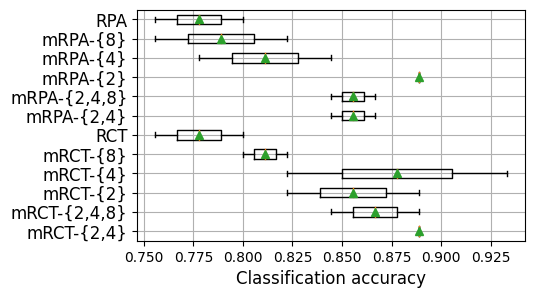

Processing tslr under scenraio cross-session...


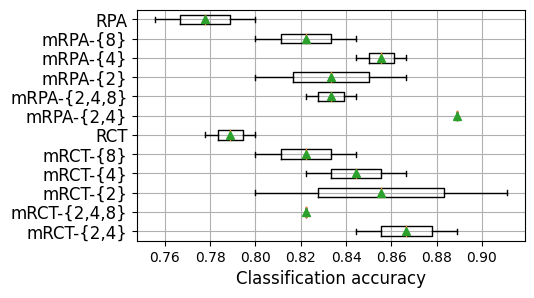

Processing csp+lr under scenraio cross-session...


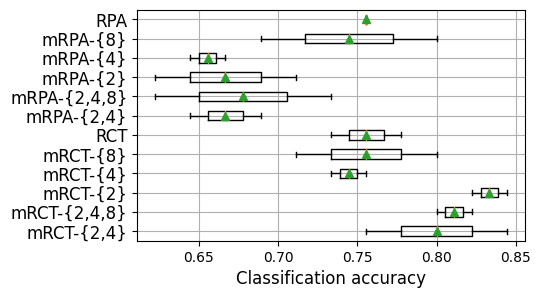

Processing csp+optsvm under scenraio cross-session...


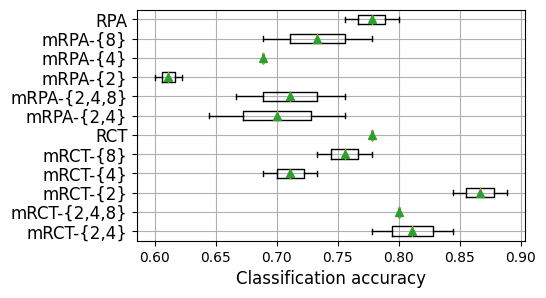

Processing fucone under scenraio cross-session...


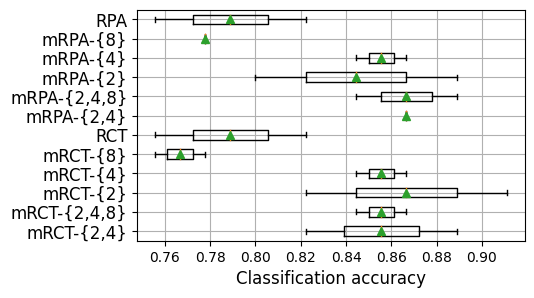

Processing mdm under scenraio within-subject...


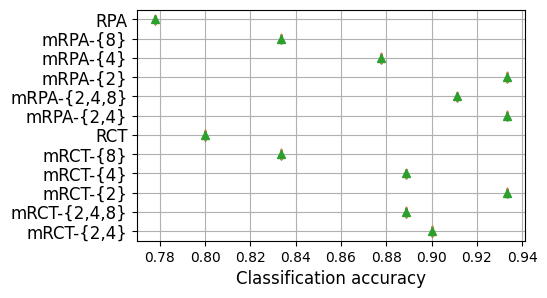

Processing tslr under scenraio within-subject...


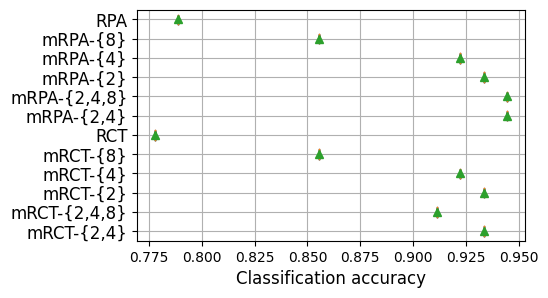

Processing csp+lr under scenraio within-subject...


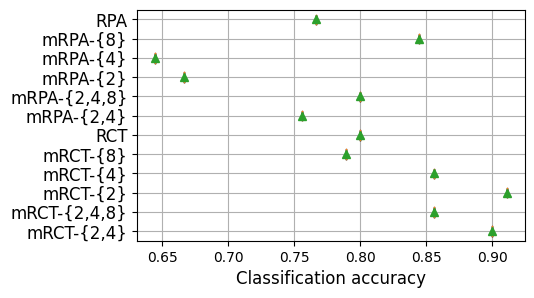

Processing csp+optsvm under scenraio within-subject...


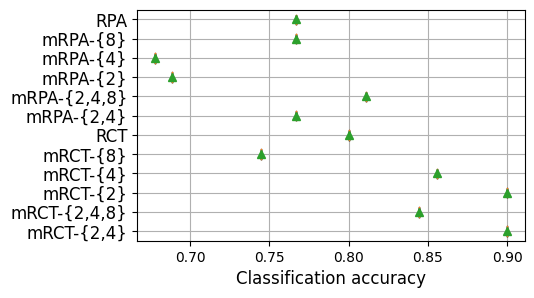

Processing fucone under scenraio within-subject...


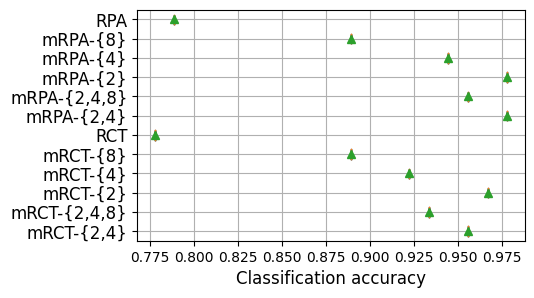

Processing mdm under scenraio cross-subject...


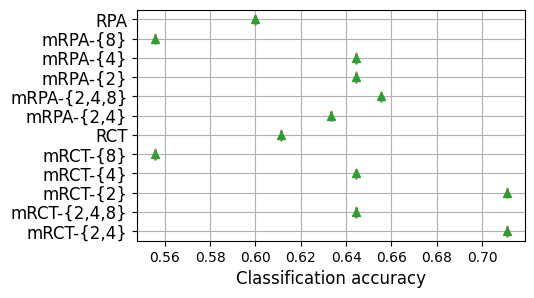

Processing tslr under scenraio cross-subject...


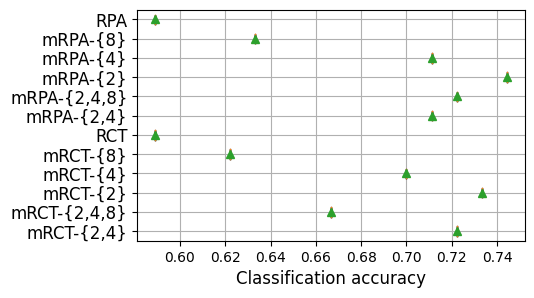

Processing csp+lr under scenraio cross-subject...


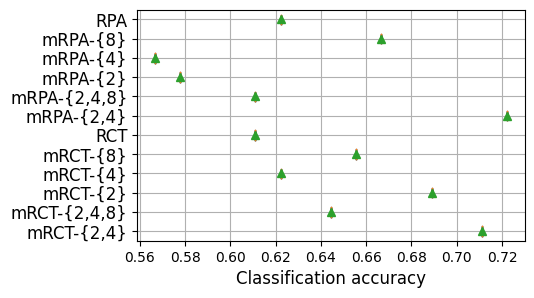

Processing csp+optsvm under scenraio cross-subject...


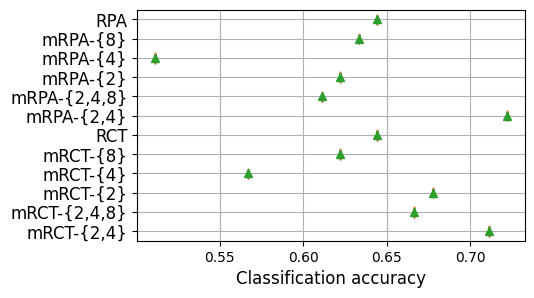

Processing fucone under scenraio cross-subject...


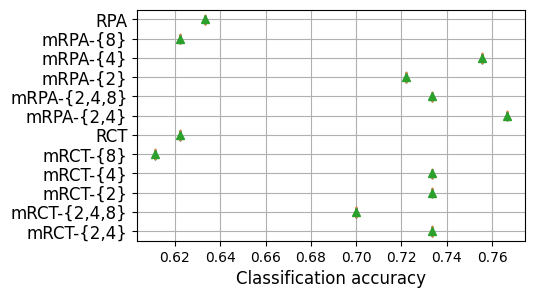

In [7]:
print("Subject: ", subjects)
print("Session: ", sessions)

for scenario in cv_list.keys():
    for algo in decoding_algo:
        print(f"Summary for {algo} under {scenario} scenario: ")
        for m in align_methods:
            print(f"mDA name: {m}")
            print("Average: ", np.mean(overall_acc[scenario][m][algo]))
            print("Std: ", np.std(overall_acc[scenario][m][algo]))
        
for scenario in cv_list.keys():
    for algo in overall_acc[scenario][align_methods[0]]:
        print(f"Processing {algo} under {scenario} scenraio...")
        fig, ax = plt.subplots(figsize=(5, 3))
        ax.boxplot(x=[overall_acc[scenario][m][algo] for m in align_methods[:]], 
                   showmeans=True, showfliers=False, vert=False)
        ax.set_yticklabels(['mRCT-{2,4}', 'mRCT-{2,4,8}', 'mRCT-{2}', 'mRCT-{4}', 'mRCT-{8}', 'RCT',
                            'mRPA-{2,4}', 'mRPA-{2,4,8}', 'mRPA-{2}', 'mRPA-{4}', 'mRPA-{8}', 'RPA'], fontsize=12)
        ax.set_xlabel('Classification accuracy', fontsize=12)
        plt.grid()
        plt.savefig(f"w_k_{scenario}_{algo}.pdf", bbox_inches='tight')
        plt.show()